In [1]:
from skope import Target
import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np
import everest
import pysyzygy as ps

In [112]:
# Generate a 12th mag light curve
star = Target(215841951, ncadences = 1000)
fpix3D, target, ferr = star.GeneratePSF(11, roll = 3)

100%|██████████| 1000/1000 [00:46<00:00, 21.68it/s]


In [115]:
# Collapse and normalize
fpix = np.array(fpix3D).reshape(-1,49)
fsap = np.sum(fpix, axis = 1)
med = np.nanmedian(fsap)
fsap /= med
fpix /= med
time = np.linspace(0, 1000 / 48., fpix.shape[0])

# Inject some transits
trn = ps.Transit(per = 3.573, rhos = 1, RpRs = 0.015, t0 = 0.5)(time)
fpix *= trn.reshape(-1,1)
fsap *= trn
true_depth = 1 - np.min(trn)

# The transit model we will recover
trn_reg = -(trn - 1) / (np.min(trn - 1))

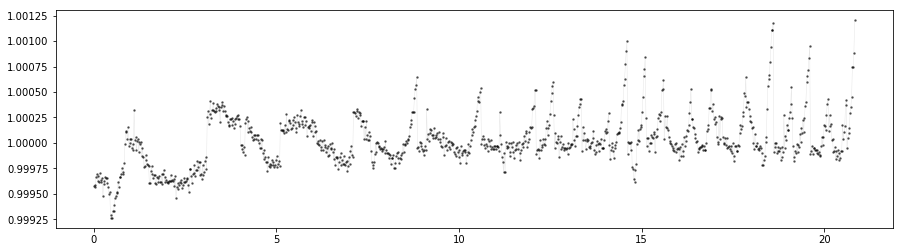

In [116]:
# Plot
fig = pl.figure(figsize = (15, 4))
pl.plot(time, fsap, 'k.', ms = 3, alpha = 0.5);
pl.plot(time, fsap, 'k-', lw = 0.5, alpha = 0.1);

In [117]:
# Compute the PLD model
A = fpix / fsap.reshape(-1,1)
w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, fsap))
model = np.dot(A, w)
fdet = fsap - model + 1

# Compute the depth after de-trending
A = trn_reg.reshape(-1,1)
depth = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, fsap - model))
overfit = 1 - depth / true_depth

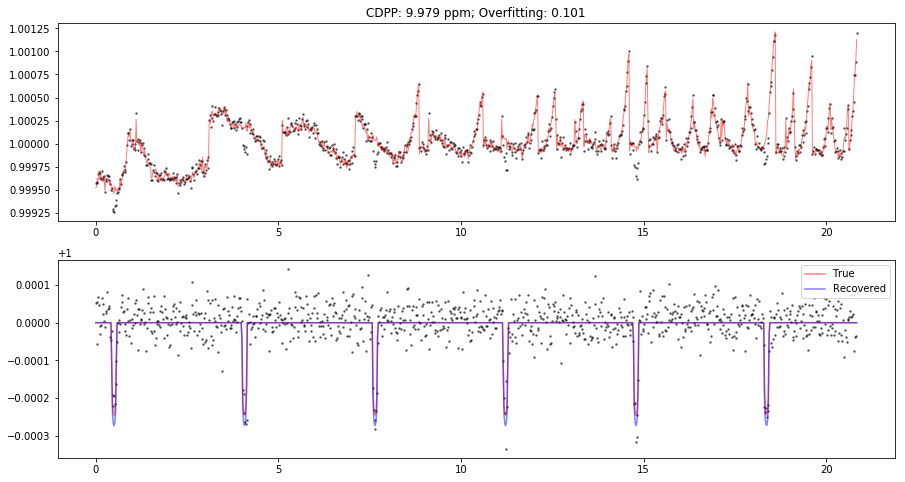

In [118]:
# Plot the results
fig, ax = pl.subplots(2, figsize = (15, 8))
ax[0].plot(time, fsap, 'k.', ms = 3, alpha = 0.5);
ax[0].plot(time, model, 'r-', lw = 1, alpha = 0.5);
ax[1].plot(time, fdet, 'k.', ms = 3, alpha = 0.5);
ax[1].plot(time, 1 + trn_reg * depth, 'r-', ms = 3, alpha = 0.5, label = 'True');
ax[1].plot(time, 1 + trn_reg * true_depth, 'b-', ms = 3, alpha = 0.5, label = 'Recovered');
ax[1].legend(loc = 'upper right')
ax[0].set_title("CDPP: %.3f ppm; Overfitting: %.3f" % (everest.k2.CDPP(fsap - model + 1), overfit));

In [119]:
# Cool. Let's work on a new PLD model.
F = np.array(fpix)

# Estimator for the diagonal of S
S = np.array(fdet)

# Estimate A
X = F / S.reshape(-1,1)
X -= np.nanmedian(X, axis = 0)
U, _, _ = np.linalg.svd(X)
A = U[:,:5]
A = np.hstack((np.ones((time.shape[0], 1)), A))

In [120]:
# Compute B
ATA = np.dot(A.T, (S ** 2)[:,None] * A)
ATF = np.dot(A.T, S[:,None] * F)
B = np.linalg.solve(ATA, ATF)

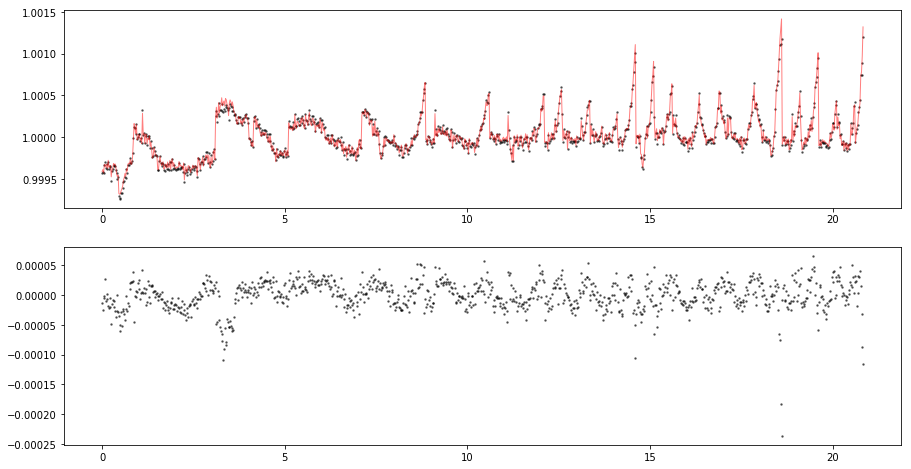

In [121]:
# Compute the model
linmodel = S[:,None] * np.dot(A, B)

fig, ax = pl.subplots(2, figsize = (15, 8))
ax[0].plot(time, np.sum(F, axis = 1), 'k.', ms = 3, alpha = 0.5);
ax[0].plot(time, np.sum(linmodel, axis = 1), 'r-', lw = 1, alpha = 0.5);
ax[1].plot(time, np.sum(F, axis = 1) - np.sum(linmodel, axis = 1), 'k.', ms = 3, alpha = 0.5);

In [149]:
# Iterate!

def Init(fpix, K = 5):
    '''
    
    '''
    
    # Compute the 1st order PLD model
    fsap = np.sum(fpix, axis = 1)
    A = fpix / fsap.reshape(-1,1)
    w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, fsap))
    model = np.dot(A, w)
    fdet = fsap - model + 1
    
    # The data matrix
    F = np.array(fpix)
    
    # Estimate S from PLD de-trended flux
    S = 0.5 + np.array(fdet) / 2
    S = np.ones_like(fdet)
    
    # Estimate A with PCA
    X = F / S.reshape(-1, 1)
    X -= np.nanmedian(X, axis = 0)
    U, _, _ = np.linalg.svd(X)
    A = U[:,:K]
    A = np.hstack((np.ones((time.shape[0], 1)), A))
    
    return F, S, A

def Step(F, S, A):
    '''
    
    '''
    
    # Dimensions
    nt = F.shape[0]
    
    # Update B
    ATA = np.dot(A.T, (S ** 2)[:,None] * A)
    ATF = np.dot(A.T, S[:,None] * F)
    B = np.linalg.solve(ATA, ATF)
    
    # Update A
    b1 = B[0,:]
    BBT = np.dot(B[1:], B[1:].T)
    BFT = np.dot(B[1:], (F / S[:,None] - b1[None,:]).T)
    A = np.hstack((np.ones(nt).reshape(-1,1), np.linalg.solve(BBT, BFT).T))
    
    # Update S
    M = np.dot(A, B)
    S = np.sum(M * F, axis = 1) / np.sum(M * M, axis = 1)
    
    return F, S, A

In [150]:
F, S, A = Init(fpix, K = 9)
for n in range(1000):
    F, S, A = Step(F, S, A)

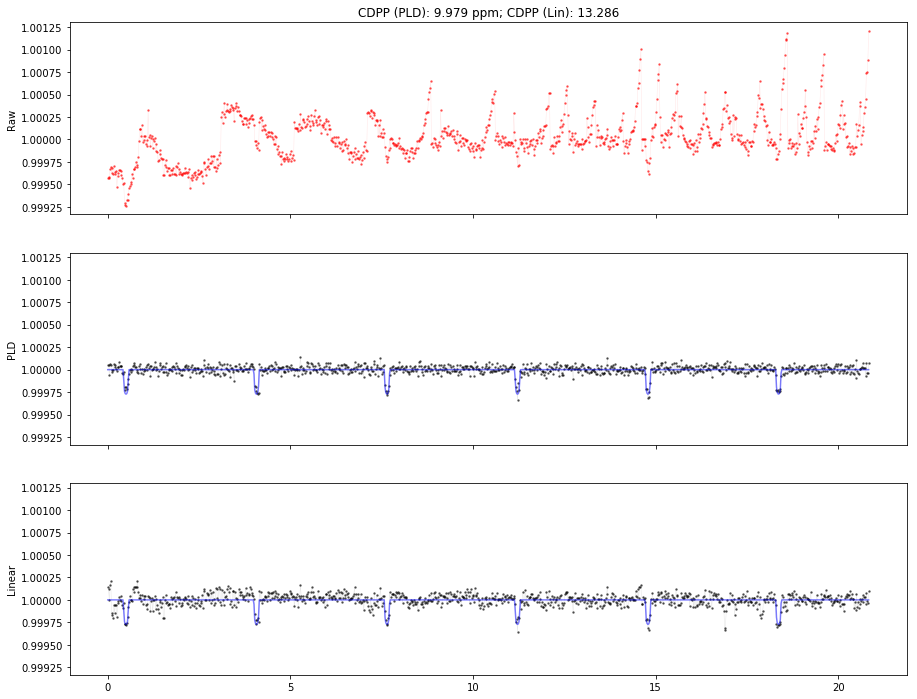

In [151]:
fig, ax = pl.subplots(3, figsize = (15, 12), sharex = True, sharey = True)
ax[0].plot(time, fsap, 'r.', ms = 3, alpha = 0.5);
ax[0].plot(time, fsap, 'r-', lw = 0.5, alpha = 0.1);
ax[0].set_ylabel("Raw")
ax[1].plot(time, fdet, 'k.', ms = 3, alpha = 0.5);
ax[1].plot(time, fdet, 'k-', lw = 0.5, alpha = 0.1);
ax[1].plot(time, 1 + trn_reg * true_depth, 'b-', ms = 3, alpha = 0.5);
ax[1].set_ylabel("PLD")
ax[2].plot(time, S, 'k.', ms = 3, alpha = 0.5);
ax[2].plot(time, S, 'k-', lw = 0.5, alpha = 0.1);
ax[2].plot(time, 1 + trn_reg * true_depth, 'b-', ms = 3, alpha = 0.5);
ax[2].set_ylabel("Linear")
ax[0].set_title("CDPP (PLD): %.3f ppm; CDPP (Lin): %.3f" % (everest.k2.CDPP(fdet), everest.k2.CDPP(S)));

In [148]:
np.prod(A.shape) + np.prod(B.shape)

10294

In [141]:
np.prod(F.shape)

49000